# Sandbox calibration
In this tutorial we will learn the basic steps to set up the _open AR Sandbox_. This not only involves tweaking of calibration parameters, but also the adjustment of your hardware components, like the Kinect and the projector.

Let's start with importing the main module:

In [12]:
import os,sys
sys.path.append('./../../../open_AR_Sandbox/')

import sandbox.sandbox as sb

### Prerequisites
The Sandbox consists of several core components (classes) which need to be initialized and can be all adjusted according to the hardware setup, your visualization preferences or different model inputs.

* **CalibrationData**: Stores all calibration parameters and allows us to save those parameters for future usage.
* **Sensor**: Provides us with a frame of distance data between the sensor and the sand surface.
* **Projector**: This is actually a dashboard with the main frame (displaying the model map), as well as optional areas for a legend, a profile view or an interactive control area.
* **Module**: The main instance that connects the other components and provides different methods dependent on the actual Sandbox application.
* **Marker (optional)**: This will allow to use the automatic calibration feature by the use of the aruco markers

While the CalibrationData and Projector components are standardised, there are different components for the other two. You can use different sensors (KinectV1, KinectV2 or a DummySensor to simulate a topography) or Modules. For Instance, the calibration process is realized in the CalibrationModule. Possible further applications cover a simple topography view (TopoModule), the visualization of geological block models (BlockModule) or the integration of live updating GemPy models (GemPyModule). Our Sandbox infrastructure allows you to easily implement other Modules for your specific application.

First, we create instances of the simple components. Here we already need to supply the resolution of our projector hardware, e.g. 1280x800 pixel. Assuming you are using a Kinect of the second generation, we create an instance of the related Sensor class. Since all components are dependent on each other we pass their instances arguments to higher level components.

In [13]:
calib = sb.CalibrationData(p_width=1280, p_height=800)
#calib = sb.CalibrationData(file = 'my_calibration.json')

In [14]:
sensor = sb.DummySensor(calib, depth_limits=(500,2000))

DummySensor initialized.


In [15]:
sensor = sb.KinectV2(calib)

KinectV2 initialized.


The projector component starts a server, the browser window that will open needs to be positioned on the secondary screen and switched into fullscreen mode manually.

In [16]:
projector = sb.Projector(calib)

Projector initialized and server started.
Please position the browser window accordingly and enter fullscreen!


Now, we can initialize our core module by passing the previous components:

In [17]:
module = sb.CalibModule(calib, sensor, projector)

Everything ready? Let's continue with the next section.

### Marker Detection **(optional)** 

The aruco markers is a class from the OpenCv package, for pose estimation with many computer vision applications. (Follow the link to read more about Aruco marker detection https://docs.opencv.org/trunk/d5/dae/tutorial_aruco_detection.html)

The basics of the Aruco marker class for sandbox purposes are described below:
* Each marker represents a point in space captured by the camera of the kinect.
* This position can be used to introduce point information to the model.
* This position may represent, e.g. wellbore location in the model, the extremes to create a 2d cross section of the 3d model, etc...  

Moreover, the aruco markers are used to perform the automatic calibration of the sandbox by fitting the projected image inside the sandbox and by croping the depth frame to the information inside the sandbox. 

So first, we start the class that will receive the information of the sensor kinect


In [18]:
marker = sb.ArucoMarkers(sensor)

Now to detect the position of the sandbox and its dimensions, please put the aruco markers in he 4 corners of the sandbox

<div class="alert alert-block alert-warning">
    <b> Carefull: </b> Be sure to place all arucos before runing the line. The code will continue running until it can find the amount of the arucos indicated
</div>

In [19]:
marker.find_markers_rgb(amount = 4)

Corners_RGB_x ids Corners_RGB_y
0          1447  15           951
1           647   5           336
2          1415   1           317
3           651   2           965

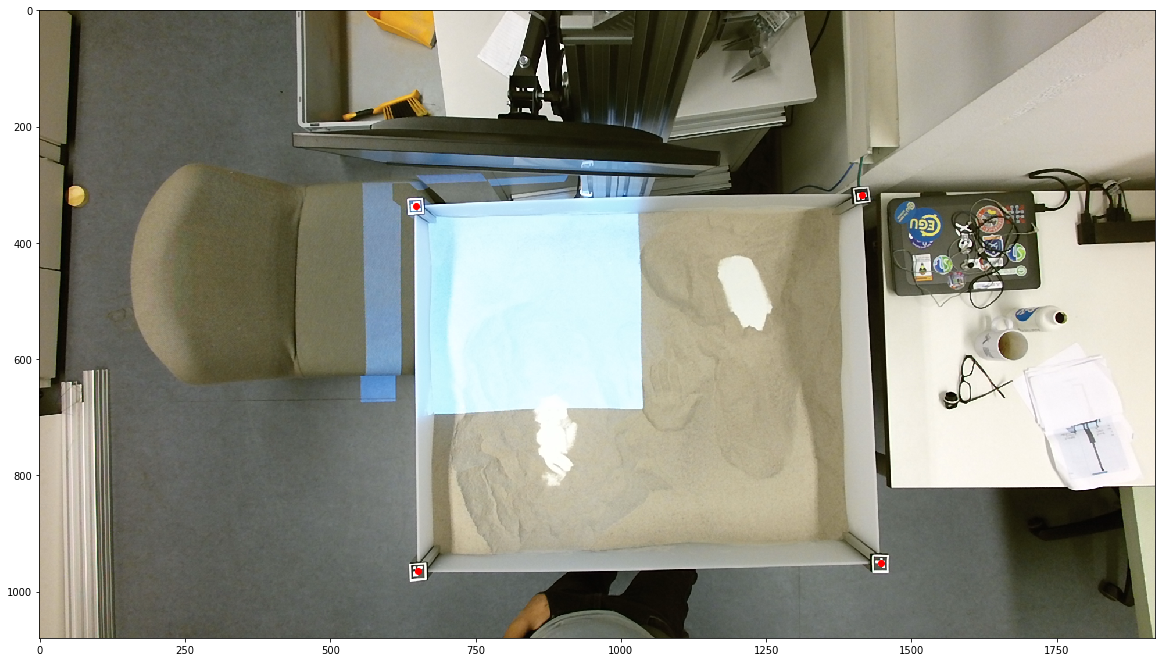

In [20]:
marker.plot_aruco_location('RGB')

Is correct the location of the markers in the image? If yes you can continue and save the location in the calibration file for future calibrations. If not, please run again until you get the desired location

In [21]:
calib.corners_as_json(marker.rgb_markers)

<div class="alert alert-block alert-warning">
    <b> Take out the aruco markers: </b> Take the markers out from the sandbox corners and save them for future usages
        
</div>

update the module with the new calibration information

In [22]:
module = sb.CalibModule(calib, sensor, projector)

## Projector calibration

**Adjust your hardware**


Please adjust the projector in a way, that at least the whole sandbox including the four corner poles are covered by the iluminated area. Make sure that the boarders of the sandbox are parallel to the boarders of the sandbox. If necessary, rotate the projector and adjust the keystone correction until the projected image is parallel to all boarders of the sandbox. Some projectors assist you with a test picture that can be switched on in the options. Depending on the color of the sand you use, you can additionally adjust the color temperature of your projector to get better colour representations. If you wish to use some additional projection areas (e.g. a legend), increase the iluminated area in order to have enough space on a panel outside the box. Also it is important that the projected area is as close to a square as possible. 

**Adjust the software**

The following command starts a calibration panel inside this notebook. You can use the four sliders until the main frame exactly covers the entire sandbox. Start with the upper left corner. Adjust the top and left margin sliders to shift the main frames position up and down and left and right. Next, use the last two sliders to adjust the size (width and height) of the main frame.

**Automatic software calibration (optional)**

Be sure to remove the corner arucos before running the automatic calibration because this will confuse the detection. 
Please move the projected image inside the sandbox by moving the top margin and the left margin. Check on the box that says "Enable Automatic Calibration", this will make functional the button to Run the automatic calibration. Keep clicking on the button until the frame fits inside the sandbox area. 

<div class="alert alert-block alert-warning">
    <b> Carefull: </b> The image will be displayed inside the aruco markers detected previously. Erroneus marker placement will result in incorrect calibration parameters 
        
</div>

In [23]:
module.calibrate_projector()

Column
    [0] Markdown(str)
    [1] WidgetBox(css_classes=['widget-box'])
        [0] IntSlider(end=780, name='Main frame top margin')
        [1] IntSlider(end=1260, name='Main frame left margin')
        [2] IntSlider(end=1280, name='Main frame width', start=10, value=600)
        [3] IntSlider(end=800, name='Main frame height', start=10, value=450)
        [4] Checkbox(name='Enable Automatic C...)
        [5] Button(button_type='success', name='Run')

## Sensor calibration

Your projector dashboard looks alright? Now, we need to calibrate the sensor so it exactly fits the projected main frame. First, we execute the module's setup function to initialize a basic model representation of the sand topography. Here that creates a simple topographic view with some color coded areas that guide you in finding the correct calibration parameters.
At this point, other modules would import your models and set up specific scale parameters.

In [24]:
module.setup()

You can see a snapshot of the topography, but the life updating is not working yet. To start this process, always call the run() function of the module. If you want to stop the process again, simply call the stop() function.

In [25]:
module.run()

Thread started or resumed...


The sensor calibration is a bit more advanced than the projector positioning. In addition to the horizontal adjustment you also need to define vertical limits of the values, the sensor supplies. For example, this prevents unwanted model recalculations, when you move your hands above the projection area.

**Adjust your hardware**

If you call the calibrate_sensor() function you will see a current snapshot of a depth representation of your sandbox. It is easy to determine the sandboxe's edges and objects next to the sandbox, like the monitor or a chair. Position the Kinect sensor phisically, so that the sensor is parallel to the sandbox surface and he outlines of the sandbox are parallel to the edges appears anymore. Each time, you have adjusted the hardware, take a new snapshot and check the visualization inside the calibration interface. Before a snapshot is taken, the software waits three seconds, allowing you to remove your hands or other objects between the sensor and the scanned surface.

**Horizontal calibration**

Afterwards, roughly adjust the first four margin sliders (blue) of the interface until the blue margin patches inside the snapshot cover the areas outisde the sandbox. Again, use the four corner poles as orientation. Those blue areas later will be cropped off by the software to focus on the area of interest.

Now, you can adjust the four margins more precisely following the life representation inside the sandbox. Place a recognizable object like a cube or a cylinder inside the sandbox to check for possible offsets. Do that in the center of the surface, as well as close to the the edges of the sandbox.

**Vertical calibration**

The vertical value range that should be registered by the sensor, can be adjusted with the red and yellow sliders. The values represent the vertical distance away from the sensor in mm. Always make sure, the yellow slider is left of the red one to avoid confusion.

Hold one hand right above the sandboxe's walls and move the yellow slider to the right until your hand is illuminated in yellow.

To calibrate the vertical maximum of the range, dig a hole inside the sand until you reach the bottom of the sandbox. Now, move the red slider until only the bottom plate is colored red. Move the slider a little bit further to the right to increase the distance slightly below the sandbox. You can always follow this process inside the interface to also get a feedback on the distances of surrounding objects behind the blue margin patches.

**Automatic calibration (optional)**

Check on the box that say "Enable Automatic Cropping". This will make functional the button to Crop the sensor frame acording to the corners detected previously by the aruco markers. Check if the cropping is accurate and correct using the sliders.

<div class="alert alert-block alert-warning">
    <b> Carefull: </b> If the hardware is moved, the position of the previous detected aruco corners will change. Please run again the "Marker Detection" section to get the correct location.        
</div>



Column
    [0] Markdown(str)
    [1] Row
        [0] WidgetBox(css_classes=['widget-box'])
            [0] Markdown(str)
            [1] IntSlider(bar_color='#084C61', end=424, name='Sensor top margin', start=1, value=10)
            [2] IntSlider(bar_color='#084C61', end=512, name='Sensor right margin', start=1, value=10)
            [3] IntSlider(bar_color='#084C61', end=424, name='Sensor bottom margin', start=1, value=10)
            [4] IntSlider(bar_color='#084C61', end=512, name='Sensor left margin', start=1, value=10)
            [5] Checkbox(name='Enable Automatic C...)
            [6] Button(button_type='success', name='Crop')
            [7] VSpacer(height=5)
            [8] Markdown(str)
            [9] IntSlider(bar_color='#DBD053', end=2000, name='Vertical minimum', value=700)
            [10] IntSlider(bar_color='#DB3A34', end=2000, name='Vertical maximum', value=1500)
            [11] Button(name='Refresh sensor f...)
        [1] Matplotlib(Figure, height=335)
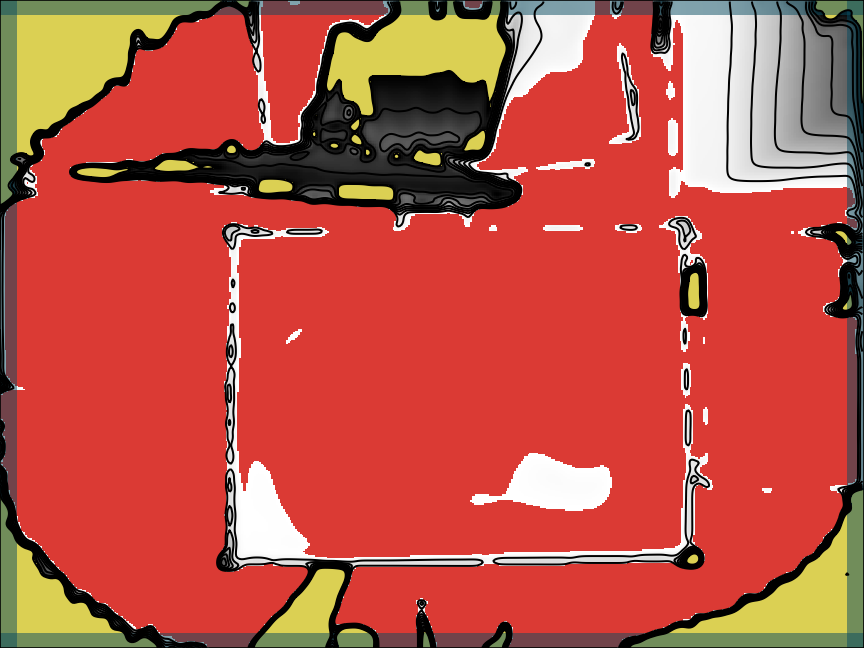

In [26]:
module.calibrate_sensor()

You have successfully calibrated your sandbox, and therefore, are ready to go :)
For the moment, let's stop the sandbox update process by calling the stop() function.

In [27]:
module.stop()

Thread stopped.


## Save calibration

Your calibration will be automatically applied to all components as long as you don't create a new CalibrationData instance or shut down the Python server. In order to save the calibration for future usages and not to go through the whole process again, you can simply save the calibration in a human-readable JSON file. Also include this file in bug reports to help us improve the Open AR Sandbox.

In [28]:
calib.save_json('my_calibration.json')

JSON configuration file saved: my_calibration.json


The next time you start the software, simply pass the file's location and name as an argument to the CalibrationData instance, before you continue with the subsequent steps:

In [ ]:
my_calib = sb.CalibrationData(file='my_calibration.json')

## Calibration shortcut
Rather than going through the calibration step by step, you can also start a bundled interface with tabs for projector, sensor and to save the calibration.

<div class="alert alert-block alert-warning">
<b>Example:</b> Use yellow boxes for examples that are not 
inside code cells, or use for mathematical formulas if needed.
</div>

In [ ]:
module.calibrate()